In [1]:
from context import QNetOptimizer as QNopt
from pennylane import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt


In [2]:
mac_bound_inequalities = [
    (np.array([[0,0,0,0,1,0,1,0,0],[1,1,0,1,0,0,0,0,0]]), 4),
    (np.array([[0,0,1,0,1,0,0,0,0],[1,1,0,1,0,0,0,0,0]]), 4),
    (np.array([[0,0,0,0,0,1,1,0,0],[1,1,0,1,0,0,0,1,0]]), 5),
    (np.array([[0,0,0,0,1,0,0,0,1],[1,1,0,1,0,1,0,0,0]]), 5),
    (np.array([[0,0,1,0,1,0,1,0,0],[2,1,0,1,0,1,0,1,0]]), 7),
    (np.array([[0,0,1,0,1,0,1,0,0],[2,2,0,1,0,0,0,1,0]]), 7),
    (np.array([[0,0,1,0,1,0,1,0,0],[2,1,0,2,0,1,0,0,0]]), 7),
    (np.array([[0,0,0,0,1,1,1,0,1],[1,1,0,1,0,0,0,1,0]]), 6),
    (np.array([[0,0,0,0,1,1,2,0,0],[2,2,0,1,0,0,0,1,0]]), 8),
    (np.array([[0,0,0,0,2,0,1,0,1],[2,2,0,1,0,1,0,0,0]]), 8),
    (np.array([[0,0,1,0,2,0,0,0,1],[2,1,0,2,0,1,0,0,0]]), 8),
    (np.array([[0,0,1,0,2,0,0,0,1],[2,1,0,2,0,0,0,1,0]]), 8),
    (np.array([[0,0,1,0,1,0,2,0,0],[2,1,0,0,0,1,0,2,0]]), 8),
    (np.array([[0,0,1,0,2,0,1,0,1],[3,2,0,2,0,1,0,0,0]]), 10),
    (np.array([[0,0,1,0,2,0,1,0,1],[3,2,0,2,0,0,0,1,0]]), 10),
    (np.array([[0,0,2,0,1,0,2,0,0],[3,1,0,1,0,2,0,2,0]]), 11),
    (np.array([[0,0,2,0,2,0,2,0,0],[3,1,0,1,0,3,0,3,1]]), 14),
    (np.array([[0,0,2,0,3,0,2,0,1],[5,3,0,3,0,1,0,1,0]]), 16),
    (np.array([[0,0,2,1,2,0,5,0,1],[4,2,0,0,0,1,0,4,0]]), 17),
]

In [3]:
def priors_scan_range(num_steps):
    x1_range = np.arange(0,1,1/num_steps)
    priors = []
    for x1 in x1_range:
        x2_range = np.arange(0,1-x1,1/num_steps)
        for x2 in x2_range:
            priors.append(np.array([x1,x2,1-x1-x2]))
        
    return priors

def plot_rate_region(rate_tuple):
    r1, r2, r_sum = rate_tuple
    
    
    r1_vals = [0,0,r_sum-r2,r1,r1,0]
    r2_vals = [0,r2,r2,r_sum-r1,0,0]
    
    plt.plot(r1_vals, r2_vals,"b-",label="Quantum")
    plt.plot([0,0,1,0],[0,1,0,0],"r--",label="Classical")
    plt.legend()
    plt.title("Multiple Access Channel Rate Regions")
    plt.xlabel("Rate 1")
    plt.ylabel("Rate 2")
    plt.show()
    
def sum_rate_cost(network_ansatz,priors_x,priors_y):
    behavior_fn = QNopt.network_behavior_fn(network_ansatz)
    
    def cost(scenario_settings):
        mac_behavior = behavior_fn(scenario_settings)
        rate_tuple = QNopt.bisender_mac_mutual_info(mac_behavior,priors_x,priors_y)
        
        return -(rate_tuple[2])
        
    return cost

In [13]:
arb_prep_nodes = [
    QNopt.PrepareNode(3, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.PrepareNode(3, [1], qml.templates.subroutines.ArbitraryUnitary, 3)
]
arb_meas_nodes = [
    QNopt.MeasureNode(1, 2, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]
arb_mac_ansatz = QNopt.NetworkAnsatz(arb_prep_nodes, arb_meas_nodes)

entanglement_prep_nodes = [
    QNopt.PrepareNode(1, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]
local_arb_meas_nodes = [
    QNopt.MeasureNode(3, 2, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.MeasureNode(3, 2, [1], qml.templates.subroutines.ArbitraryUnitary, 3),
]

def local_arb_meas_circuit(settings, wires):
    qml.templates.subroutines.ArbitraryUnitary(settings[0:3],wires=[wires[0]])
    qml.templates.subroutines.ArbitraryUnitary(settings[3:6],wires=[wires[1]])

local_meas_node = [
    QNopt.MeasureNode(1,2,[0,1],local_arb_meas_circuit,6)
]

ea_mac_ansatz = QNopt.NetworkAnsatz(entanglement_prep_nodes, local_arb_meas_nodes)
local_mac_ansatz = QNopt.NetworkAnsatz(arb_prep_nodes, local_meas_node)

In [17]:
local_settings = local_mac_ansatz.rand_scenario_settings()
local_cost = QNopt.linear_probs_cost(local_mac_ansatz, mac_bound_inequalities[18][0])
local_opt_dict = QNopt.gradient_descent(local_cost, local_settings, step_size=0.1, num_steps=150, sample_width=25)


iteration :  0 , score :  12.951336970934175
iteration :  25 , score :  16.999102494550158
iteration :  50 , score :  16.999999156417243
iteration :  75 , score :  16.999999999093212
iteration :  100 , score :  16.99999999999884
iteration :  125 , score :  16.999999999999993


id :  107
rate tuple :  (0.9709505944546697, 0.9709505944546688, 1.9419011889093385)
priors tuple :  (tensor([0.2, 0.4, 0.4], requires_grad=True), tensor([0. , 0.4, 0.6], requires_grad=True))


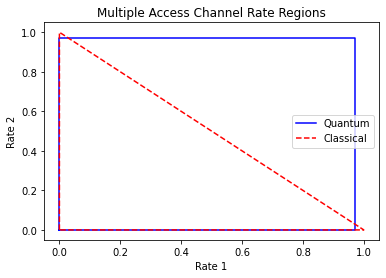

In [18]:
local_mac_behavior = QNopt.network_behavior_fn(local_mac_ansatz)
local_opt_behavior = local_mac_behavior(local_opt_dict["opt_settings"])

local_rates = []
priors = []
for priors_x in priors_scan_range(5):
    for priors_y in priors_scan_range(5):
        priors.append((priors_x, priors_y))
        local_rates.append(QNopt.bisender_mac_mutual_info(local_opt_behavior, priors_x, priors_y))
        
local_rate_sums = [rate_set[2] for rate_set in local_rates]
max_local_rate_sum = max(local_rate_sums)
max_local_rate_id = local_rate_sums.index(max_local_rate_sum)
max_local_rate_tuple = local_rates[max_local_rate_id]

print("id : ", max_local_rate_id)
print("rate tuple : ", max_local_rate_tuple)
print("priors tuple : ", priors[max_local_rate_id])
print(np.sum(np.sum(mac_bound_inequalities[18][0]*)))
plot_rate_region(max_local_rate_tuple)


In [ ]:
arb_settings = arb_mac_ansatz.rand_scenario_settings()
arb_cost = QNopt.linear_probs_cost(arb_mac_ansatz, mac_bound_inequalities[5][0])
arb_opt_dict = QNopt.gradient_descent(arb_cost, arb_settings, step_size=0.1, num_steps=150, sample_width=25)


In [ ]:
arb_mac_behavior = QNopt.network_behavior_fn(arb_mac_ansatz)
arb_opt_behavior = arb_mac_behavior(arb_opt_dict["opt_settings"])

arb_rates = []
priors = []
for priors_x in priors_scan_range(5):
    for priors_y in priors_scan_range(5):
        priors.append((priors_x, priors_y))
        arb_rates.append(QNopt.bisender_mac_mutual_info(arb_opt_behavior, priors_x, priors_y))
        
arb_rate_sums = [rate_set[2] for rate_set in arb_rates]
max_arb_rate_sum = max(arb_rate_sums)
max_arb_rate_id = arb_rate_sums.index(max_arb_rate_sum)
max_arb_rate_tuple = arb_rates[max_arb_rate_id]

print("id : ", max_arb_rate_id)
print("rate tuple : ", max_arb_rate_tuple)
print("priors tuple : ", priors[max_arb_rate_id])
plot_rate_region(max_arb_rate_tuple)


In [ ]:
ea_settings = ea_mac_ansatz.rand_scenario_settings()
ea_cost = QNopt.linear_probs_cost(ea_mac_ansatz, mac_bound_inequalities[18][0])
ea_opt_dict = QNopt.gradient_descent(ea_cost, ea_settings, step_size=0.1, num_steps=150, sample_width=25)

In [ ]:
ea_mac_behavior = QNopt.network_behavior_fn(ea_mac_ansatz)
ea_opt_behavior = ea_mac_behavior(ea_opt_dict["opt_settings"])


ea_rates = []
for priors_x in priors_scan_range(5):
    for priors_y in priors_scan_range(5):
        ea_rates.append(QNopt.bisender_mac_mutual_info(ea_opt_behavior, priors_x, priors_y))
        
ea_rate_sums = [rate_set[2] for rate_set in ea_rates]
max_ea_rate_sum = max(ea_rate_sums)
max_ea_rate_id = ea_rate_sums.index(max_ea_rate_sum) 
max_ea_rate_tuple = ea_rates[max_ea_rate_id]

print("id : ", max_ea_rate_id)
print("rate tuple : ", max_ea_rate_tuple)

plot_rate_region(max_ea_rate_tuple)

In [ ]:
arb_rand_settings = arb_mac_ansatz.rand_scenario_settings()
arb_sum_rate_cost = sum_rate_cost(arb_mac_ansatz, np.ones(3)/3, np.ones(3)/3)
QNopt.gradient_descent(arb_sum_rate_cost, arb_rand_settings, step_size=0.1, num_steps=50, sample_width=5)